# Проект по исследованию интернет-магазина «Подарочек»

### Описание проекта

Исследование данных онлайн-магазина подарков, сегментация клиентов и проверка статистических гипотез с целью выявления скрытых взаимосвязей и определения стратегии развития

### Описание данных

Данные представлены в виде двух датасетов. В одном датасете содержиться информация о наименованиях в заказах. У нас есть дата записи, id заказа и клиента, количество и цена товара, группа и id записи, а также id страны заказа. Во втором датасете содержиться информация о id записи и сама запись. Два датасета можно объединить на основе id записи.

### План проекта

1. Получение, осмотр и объединение данных
2. Предобработка и начало исследовательского анализа
3.  Расчёт метрик
4. RFM-сегментацию клиентов
5. Проверка статистических гипотез
6. Вывод

# Шаг 1. Получение, осмотр и объединение данных

1. Загрузите данные из csv-файлов в датафреймы.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
try:
    gift = pd.read_csv('/Users/macbook/Desktop/gift.csv')
except FileNotFoundError:
    gift = pd.read_csv('https://code.s3.yandex.net/datasets/gift.csv')
                         

gift_entry = pd.read_csv('https://code.s3.yandex.net/python-for-analytics/gift_entry.csv', sep=';')

2. Изучите общую информацию о датафреймах.

In [3]:
gift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356940 entries, 0 to 356939
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   entry_date   356940 non-null  object
 1   order_id     356940 non-null  int64 
 2   customer_id  356940 non-null  int64 
 3   quantity     356940 non-null  int64 
 4   price        356940 non-null  int64 
 5   name_clust   356940 non-null  int64 
 6   entry_id     356940 non-null  int64 
 7   country_id   356940 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 21.8+ MB


In [4]:
gift_entry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry_id  2917 non-null   int64 
 1   entry     2916 non-null   object
dtypes: int64(1), object(1)
memory usage: 45.7+ KB


# 

3. Проверим датафрейм на наличине пропусков. В ходе проверки был обнаружен 1 пропуск в таблице gift_entry в столбце entry. Удалим эту строку.

In [5]:
gift.isna().sum()

entry_date     0
order_id       0
customer_id    0
quantity       0
price          0
name_clust     0
entry_id       0
country_id     0
dtype: int64

In [6]:
gift.isnull().sum()

entry_date     0
order_id       0
customer_id    0
quantity       0
price          0
name_clust     0
entry_id       0
country_id     0
dtype: int64

In [7]:
gift_entry.isna().sum()

entry_id    0
entry       1
dtype: int64

In [8]:
gift_entry = gift_entry.dropna()

In [9]:
gift.isnull().sum()

entry_date     0
order_id       0
customer_id    0
quantity       0
price          0
name_clust     0
entry_id       0
country_id     0
dtype: int64

Посмотрим на стобец entry_id в датасете gift.

In [10]:
gift['entry_id']

0          891
1         1596
2          166
3         1810
4         2585
          ... 
356935    2723
356936    1246
356937    1241
356938    2811
356939    1818
Name: entry_id, Length: 356940, dtype: int64

Проверим все ли записи в столбце entry_id из датасета gift_entry есть в датасете gift

In [11]:
gift_entry['entry_id'].isin(gift['entry_id']).sum() == len(gift_entry['entry_id'])

True

Все значения столбца entry_id из gift_entry входят в датасет gift

3. Проверьте наличие дубликатов, примите решение об удалении.

In [12]:
f'Посчитаем количество дубликатов. В ходе проверки было обнаружено {gift.duplicated().sum()} строк - дубликатов в таблице gift и {gift_entry.duplicated().sum()} строк - дубликатов в таблице gift_entry.'

'Посчитаем количество дубликатов. В ходе проверки было обнаружено 3573 строк - дубликатов в таблице gift и 0 строк - дубликатов в таблице gift_entry.'

In [13]:
f'В таблице gift дубликаты составляют {round((gift.duplicated().sum() / len(gift))*100,1)}.% от общего количества строк.'

'В таблице gift дубликаты составляют 1.0.% от общего количества строк.'

Удалим строки - дубликаты

In [14]:
gift.drop_duplicates(inplace = True)

4. Рассмотрите типы данных в каждом столбце, приведите типы (если нужно).

Все столбцы, кроме entry_date представлены в виде данных типа int. entry_date представлены в виде данных типа object. Переведём эти данные в тип datetime.

In [15]:
gift.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353367 entries, 0 to 356939
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   entry_date   353367 non-null  object
 1   order_id     353367 non-null  int64 
 2   customer_id  353367 non-null  int64 
 3   quantity     353367 non-null  int64 
 4   price        353367 non-null  int64 
 5   name_clust   353367 non-null  int64 
 6   entry_id     353367 non-null  int64 
 7   country_id   353367 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 24.3+ MB


In [16]:
gift['entry_date'] = pd.to_datetime(gift['entry_date'], format='%d/%m/%Y %H:%M')

In [17]:
gift.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353367 entries, 0 to 356939
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   entry_date   353367 non-null  datetime64[ns]
 1   order_id     353367 non-null  int64         
 2   customer_id  353367 non-null  int64         
 3   quantity     353367 non-null  int64         
 4   price        353367 non-null  int64         
 5   name_clust   353367 non-null  int64         
 6   entry_id     353367 non-null  int64         
 7   country_id   353367 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 24.3 MB


В таблице gift_entry id представлены в виде типа данных - int, второй столбец является объектом. Здесь ничего менять не надо.

In [18]:
gift_entry.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2916 entries, 1 to 2916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry_id  2916 non-null   int64 
 1   entry     2916 non-null   object
dtypes: int64(1), object(1)
memory usage: 68.3+ KB


6. Проверьте соответствие идентификационных номеров.

Получается, что у нас только 2916 записей в которых присутствует информация о тексте, при общем количестве записей в 353367.

In [19]:
gift.shape

(353367, 8)

In [20]:
gift_entry.shape

(2916, 2)

Проверим пересечение данных по entry_id. Данные из gift_entry входят в gift.

In [21]:
gift_entry['entry_id'].isin(gift['entry_id']).sum() == len(gift_entry['entry_id'])

True

Объединим две таблицы на основе внешнего объединения. У нас вышло, что у каждой записи из gift_entry была соответствующая запись в gift. Поэтому общее число строк не изменилась после объединения.

In [22]:
gift_df = gift.merge(gift_entry, on='entry_id', how='outer')

In [23]:
gift_df.shape

(353367, 9)

# Шаг 2. Предобработка и начало исследовательского анализа

1. Найдите выбросы и аномальные значения в столбцах price и quantity, рассчитайте сумму стоимости каждой товарной позиции в датасете, примите и реализуйте решение о сохранении или отбрасывании подозрительных данных.

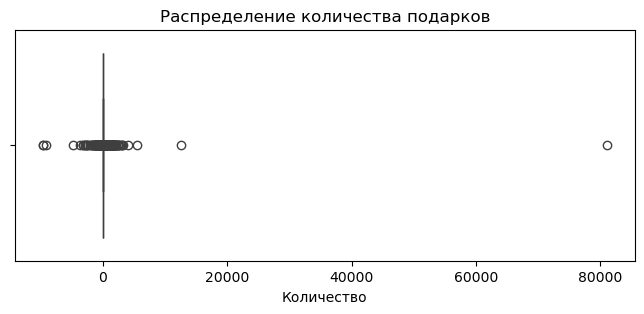

In [24]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=gift_df, x='quantity')
plt.title('Распределение количества подарков')
plt.xlabel('Количество')
plt.show() 

На ящике с усами для столбца с количеством видно, что данные сосредоточены возле 0, также существуют аномальные отрицательные значения и выброс со значением больше 80.000

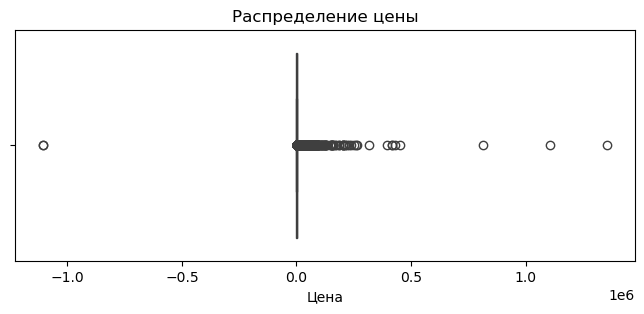

In [25]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=gift_df, x='price')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.show() 

На ящике с усами для столбца с ценой видно, что данные сосредоточены возле 0, также существуют аномальные отрицательные значения и выбросы

Аномальные отрицательные данные в столбце с количеством составляют всего 0.03% от всех данных. Удалим их.

In [26]:
a=(len(gift_df[gift_df['quantity'] < 0]) / len(gift_df))*100

In [27]:
f'Аномальные отрицательные данные в столбце с количеством составляют всего {round(a,4)}.% от всех данных. Удалим их.'

'Аномальные отрицательные данные в столбце с количеством составляют всего 0.2935.% от всех данных. Удалим их.'

In [28]:
gift_df = gift_df[gift_df['quantity'] > 0]

У нас всего 2 значения, где цена отрицательна. Удалим эти значения.

In [29]:
gift_df[gift_df['price'] < 0]

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry
337983,2019-12-08 14:51:00,29852,-1,1,-1106206,0,1548,28,КОРРЕКТИРОВКА БЕЗНАДЕЖНЫЙ ДОЛГ
337984,2019-12-08 14:52:00,29853,-1,1,-1106206,0,1548,28,КОРРЕКТИРОВКА БЕЗНАДЕЖНЫЙ ДОЛГ


In [30]:
gift_df = gift_df[gift_df['price'] > 0]

Рассмотрим аномально высокие значения в столбце с количеством. Значение 80955 очень похоже на какую то ошибку. Его лучше удалить.

In [31]:
gift_df[gift_df['quantity']>80000]

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry
353366,2019-09-12 09:15:00,48149,3554,80995,208,325,2204,28,"поделка из бумаги, маленькая птичка"


In [32]:
gift_df = gift_df[gift_df['quantity'] < 80000]

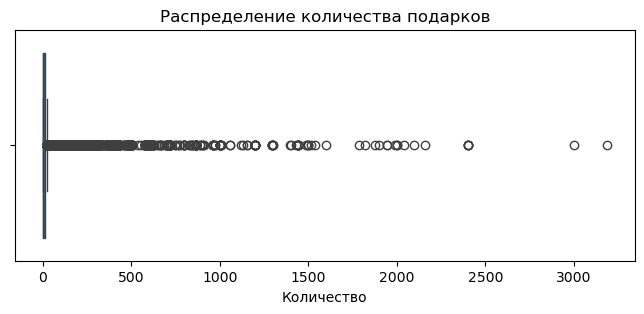

In [33]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=gift_df, x='quantity')
plt.title('Распределение количества подарков')
plt.xlabel('Количество')
plt.show() 

Рассмотрим аномально высокие значения в столбце с ценой. По их описанию можно предположить, что они не относятся к непосредственной продаже подарков. Для корректности анализа их лучше удалить.

In [34]:
gift_df.sort_values(by='price').tail(10)

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry
187875,2019-09-19 16:14:00,34019,-1,1,265395,0,2375,8,РУКОВОДСТВО
187893,2019-03-10 16:44:00,36048,4498,1,315595,0,2375,28,РУКОВОДСТВО
187916,2019-10-19 11:18:00,38417,7256,1,394932,0,2375,22,РУКОВОДСТВО
187930,2019-10-27 14:13:00,39743,7464,1,416106,0,2375,5,РУКОВОДСТВО
187931,2019-10-27 14:20:00,39746,7464,1,416106,0,2375,5,РУКОВОДСТВО
187837,2019-07-18 12:30:00,27039,-1,1,428763,0,2375,28,РУКОВОДСТВО
171922,2019-11-08 10:14:00,29621,-1,1,450517,0,180,28,"ДОТКОМ, ПОЧТОВЫЕ РАСХОДЫ"
12787,2019-03-05 13:46:00,18363,3971,1,814275,1,2253,28,ПОЧТОВЫЕ РАСХОДЫ
337982,2019-12-08 14:50:00,29851,-1,1,1106206,0,1548,28,КОРРЕКТИРОВКА БЕЗНАДЕЖНЫЙ ДОЛГ
259129,2018-07-12 15:08:00,4298,-1,1,1354133,14,1493,28,КОМИССИЯ АМАЗОН


Можно заметить, что все записи не являющиеся подарками напечатаны в верхнем регистре. Проверим другие значения в врехнем регистре.

In [35]:
gift_df[gift_df['entry'].str.isupper()]['entry'].unique()

array(['ПОЧТОВЫЕ РАСХОДЫ', 'ДОТКОМ, ПОЧТОВЫЕ РАСХОДЫ', 'АВИАПОЧТА',
       'РУКОВОДСТВО', 'ОТКРЫТИЕ БАНКОВСКОГО СЧЕТА', 'КОМИССИЯ АМАЗОН',
       'ОБРАЗЦЫ', 'КОРРЕКТИРОВКА БЕЗНАДЕЖНЫЙ ДОЛГ', 'КРАСИВО ЗАВЕРНУТЬ'],
      dtype=object)

У нас получилось ещё 4 значения, которые можно удалить. Удалим все значения, которые не являются подарками.

In [36]:
extra_values = ['РУКОВОДСТВО', 'ДОТКОМ, ПОЧТОВЫЕ РАСХОДЫ', 
                'ПОЧТОВЫЕ РАСХОДЫ', 'КОРРЕКТИРОВКА БЕЗНАДЕЖНЫЙ ДОЛГ',
                'КОМИССИЯ АМАЗОН','АВИАПОЧТА','ОТКРЫТИЕ БАНКОВСКОГО СЧЕТА',
                'ОБРАЗЦЫ','КРАСИВО ЗАВЕРНУТЬ']

gift_df = gift_df[~gift_df['entry'].isin(extra_values)]

In [37]:
gift_df[gift_df['entry'].str.isupper()]

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry


Ещё раз рассмотрим высокие значения цены.

In [38]:
gift_df.sort_values(by='price', ascending=False).head(10)

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry
271328,2019-04-28 12:22:00,18059,5027,1,29500,671,2563,28,старинный синий кухонный шкаф
271324,2019-03-14 11:38:00,13146,6548,1,29500,671,2563,28,старинный синий кухонный шкаф
223435,2018-02-12 18:06:00,3501,6855,1,29500,596,1112,28,винтажный красный кухонный шкаф
223461,2019-05-26 16:25:00,21502,6985,1,29500,596,1112,28,винтажный красный кухонный шкаф
223449,2019-04-02 15:32:00,9919,5158,1,29500,596,1112,28,винтажный красный кухонный шкаф
223440,2018-12-16 08:41:00,5746,3393,1,29500,596,1112,28,винтажный красный кухонный шкаф
271325,2019-03-25 14:19:00,14480,6548,1,29500,671,2563,28,старинный синий кухонный шкаф
223442,2019-10-01 14:57:00,7313,2594,1,29500,596,1112,28,винтажный красный кухонный шкаф
266985,2019-07-03 17:42:00,12566,2183,1,19500,740,1191,28,двойное кресло античный белый металл
266992,2019-05-16 15:29:00,20046,2810,1,19500,740,1191,28,двойное кресло античный белый металл


Самые высокие значения цены можно наблюдать у антикварной мебели. Эти значения скорее всего не являются какой-либо аномалией, их удалять не будем.

Добавим столбце со стоимостью заказа (цена * количество)

In [39]:
 gift_df['position_sum'] = gift_df['quantity'] * gift_df['price']

In [40]:
gift_df.head()

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry,position_sum
0,2018-01-12 08:26:00,3031,2150,6,339,740,891,28,белый металлический фонарь,2034
1,2018-01-12 09:02:00,3039,2150,6,339,740,891,28,белый металлический фонарь,2034
2,2018-01-12 09:32:00,3041,2150,6,339,740,891,28,белый металлический фонарь,2034
3,2018-01-12 10:51:00,3062,2150,6,339,740,891,28,белый металлический фонарь,2034
4,2018-01-12 11:33:00,3072,2150,8,339,740,891,28,белый металлический фонарь,2712


2. Изучите столбцы order_id, customer_id, name_clust, entry_id и country_id.

В столбце order_id не наблюдается неестественных значений.

In [41]:
gift_df['order_id'].describe()
gift_df[gift_df['order_id']==0]

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry,position_sum


В столбце customer_id имеются значения -1. Такие значения составляют 25% от всех данных. Удаление такого количества данных приведёт с большой потери информации, поэтому их лучше оставить.

In [42]:
len(gift_df[gift_df['customer_id'] == -1]) / len(gift_df)

0.2562631467333054

In [43]:
gift_df['customer_id'].describe()

count    348946.000000
mean       3495.628097
std        2535.695810
min          -1.000000
25%          -1.000000
50%        3640.000000
75%        5633.000000
max        7653.000000
Name: customer_id, dtype: float64

Рассмотрим эти данные подробнее.

In [44]:
customer_position_mean = gift_df.groupby('customer_id').agg({'position_sum':'mean'})
customer_position_mean.iloc[0]

position_sum    1104.668471
Name: -1, dtype: float64

In [45]:
customer_position_mean['position_sum'].median()

1693.9222222222222

Среднее значение стоимости позиции для клиентов с id -1 чуть меньше, чем медианное значение для всех клиентов.

Сравним комментарии к заказам.

In [46]:
gift_df[gift_df['customer_id']==-1].sample(10)

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry,position_sum
173859,2019-05-27 15:18:00,21626,-1,1,1246,576,155,28,Винтажный контейнер для кошачьего корма с кремом,1246
80778,2019-06-12 10:05:00,47420,-1,1,750,70,1379,28,катушка из ленты лепит снеговика,750
238833,2019-06-07 16:33:00,25829,-1,1,413,160,2802,28,цинковые колокольчики в народном искусстве,413
149096,2019-04-02 10:40:00,9848,-1,2,246,380,61,28,t-light из стекла рифленый антик,492
281979,2019-11-16 15:16:00,43503,-1,1,663,790,1859,28,набор из 2 кухонных полотенец с дизайном кладовой,663
184970,2019-12-07 16:11:00,26482,-1,1,83,885,2121,28,"перо-перо, светло-розовое",83
50447,2019-02-17 10:34:00,10873,-1,1,829,608,1528,28,корзина для пикника плетеная маленькая,829
203200,2019-12-07 16:20:00,26483,-1,1,246,927,447,28,Набор/6 свечей T-Light с розовой птицей,246
241932,2018-12-21 15:20:00,6406,-1,1,591,404,2285,28,раздвоенная свеча кактуса,591
121806,2019-06-07 16:33:00,25829,-1,5,83,451,87,28,Безумное украшение в форме сердца из ромашек,415


Описания к заказам не содержат ничего особенного, что могло бы выделить клиентов с id -1 из общей массы

Визуально кажется, что все клиенты с id -1 из страны с кодом 28. Проверим данную гипотезу.

In [47]:
len(gift_df[(gift_df['country_id']==28) & (gift_df['customer_id']==-1)]) / len(gift_df[gift_df['customer_id']==-1])

0.99407304690121

Получилось, что почти все клиенты с id -1 из страны с кодом 28. Проверим,может дело в том, что клиентов из страны с кодом 28 в целом больше.

In [48]:
gift_df.groupby('country_id').agg({'customer_id':'count'}).sort_values(by='customer_id', ascending=False).head()

,customer_id
country_id,
28,324892
6,6274
5,5927
16,1713
23,1650


Так и вышло, почти все клиенты из страны с кодом 28.

В ходе проверки не было выявлено особенностей для клиентов с id -1.

В столбце name_clust не наблюдается неестественных значений.

In [49]:
gift_df['name_clust'].describe()

count    348946.000000
mean        474.036198
std         255.706446
min           1.000000
25%         250.000000
50%         452.000000
75%         706.000000
max         929.000000
Name: name_clust, dtype: float64

В столбце entry_id не наблюдается неестественных значений.

In [50]:
gift_df['entry_id'].describe()

count    348946.000000
mean       1525.550277
std         828.208258
min           1.000000
25%         900.000000
50%        1561.000000
75%        2223.000000
max        2916.000000
Name: entry_id, dtype: float64

В столбце country_id присутствуют нулевые значения.

In [51]:
gift_df['country_id'].describe()

count    348946.000000
mean         26.784961
std           4.913020
min           0.000000
25%          28.000000
50%          28.000000
75%          28.000000
max          29.000000
Name: country_id, dtype: float64

3. Изучите полноту данных, анализируя время записей. Посчитайте по месяцам количество дней, в которых не было продаж. Выберите период для анализа, содержащий основную часть данных, и далее работайте только с актуальными данными.

Создаём дополнительные столбцы с датой и месяцем.

In [52]:
gift_df['date'] = gift_df['entry_date'].dt.date
gift_df['month'] = gift_df['entry_date'].dt.month

Сгруппируем данные по количеству заказов за каждую дату.

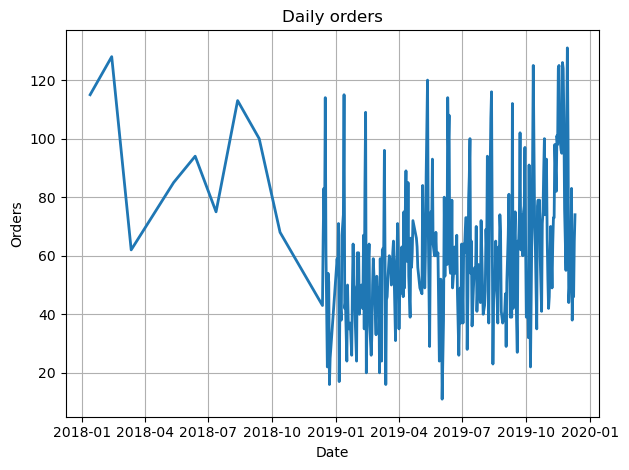

In [53]:
df_date = gift_df.groupby('date').agg({'order_id':'nunique'})
df_date['date_'] = df_date.index


plt.plot(df_date['date_'], df_date['order_id'],  
         linestyle='-',  
         linewidth=2)  

plt.title('Daily orders')


plt.xlabel('Date')
plt.ylabel('Orders') 

plt.tight_layout()

plt.grid(True)  

plt.show()

Для анализа возьмём данные за 2019 год. Однако можно заметить, что у нас неполные данные за декабрь 2019, поэтому возьмём данные с января по ноябрь 2019 года.

In [54]:
#CODE REVIEW
df_raw = pd.read_csv("https://code.s3.yandex.net/datasets/gift.csv", 
                     parse_dates=["entry_date"],
                    dayfirst=True)\
    .assign(date=lambda row: pd.to_datetime(row["entry_date"].dt.date))\
    .query("price > 0 and quantity > 0")
df_raw.head()

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,date
0,2018-01-12 08:26:00,3031,2150,6,339,740,891,28,2018-01-12
1,2018-01-12 08:26:00,3031,2150,8,275,132,1596,28,2018-01-12
2,2018-01-12 08:26:00,3031,2150,6,339,197,166,28,2018-01-12
3,2018-01-12 08:26:00,3031,2150,2,765,767,1810,28,2018-01-12
4,2018-01-12 08:26:00,3031,2150,6,425,383,2585,28,2018-01-12


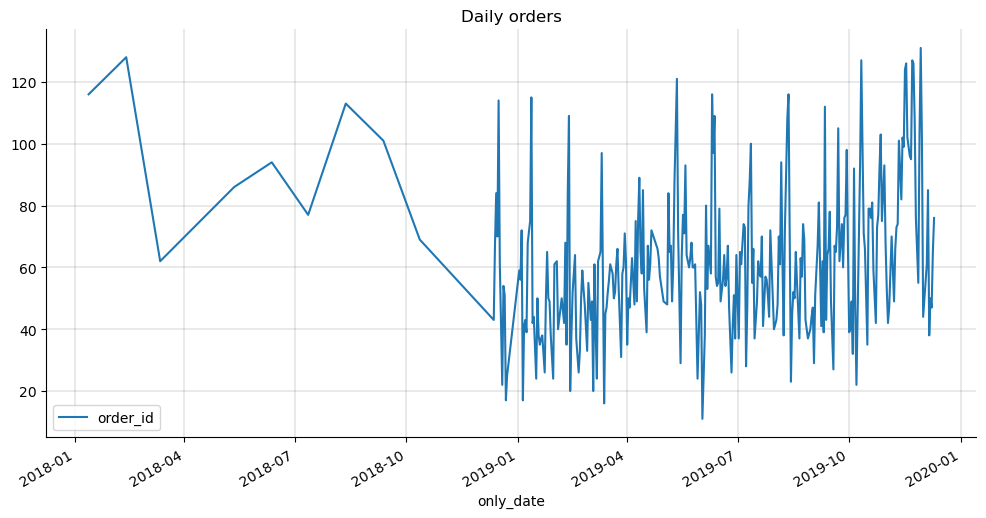

In [55]:
fig, ax = plt.subplots( figsize=(12, 6))
sns.despine(left=False, ax=ax)

df_raw.assign(only_date=lambda row: pd.to_datetime(row["date"].dt.date))\
    .groupby("only_date")\
    .agg({"order_id": "nunique"})\
    .plot(ax=ax)
ax.grid( color='grey', lw=0.25)
ax.set_title("Daily orders");


Оставляем только данные с января по ноябрь 2019 года.

In [56]:
gift_df

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry,position_sum,date,month
0,2018-01-12 08:26:00,3031,2150,6,339,740,891,28,белый металлический фонарь,2034,2018-01-12,1
1,2018-01-12 09:02:00,3039,2150,6,339,740,891,28,белый металлический фонарь,2034,2018-01-12,1
2,2018-01-12 09:32:00,3041,2150,6,339,740,891,28,белый металлический фонарь,2034,2018-01-12,1
3,2018-01-12 10:51:00,3062,2150,6,339,740,891,28,белый металлический фонарь,2034,2018-01-12,1
4,2018-01-12 11:33:00,3072,2150,8,339,740,891,28,белый металлический фонарь,2712,2018-01-12,1
...,...,...,...,...,...,...,...,...,...,...,...,...
353361,2019-08-12 14:38:00,48078,5585,4,295,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,1180,2019-08-12,8
353362,2019-08-12 15:51:00,48098,6202,32,255,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,8160,2019-08-12,8
353363,2019-08-12 16:30:00,48105,-1,1,579,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,579,2019-08-12,8
353364,2019-09-12 10:03:00,48158,-1,3,579,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,1737,2019-09-12,9


In [57]:
gift_df = gift_df[(gift_df['entry_date'].dt.year == 2019) & (gift_df['entry_date'].dt.month != 12)]

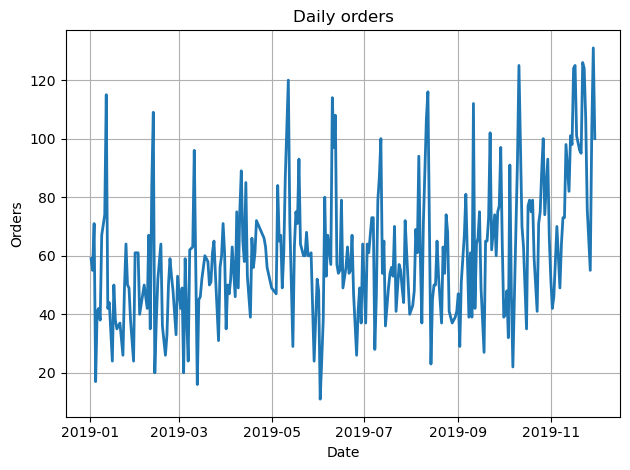

In [58]:
df_date_new = gift_df.groupby('date').agg({'order_id':'nunique'})
df_date_new['date_'] = df_date_new.index


plt.plot(df_date_new['date_'], df_date_new['order_id'],  
         linestyle='-',  
         linewidth=2)  

plt.title('Daily orders')


plt.xlabel('Date')
plt.ylabel('Orders') 

plt.tight_layout()

plt.grid(True)  

plt.show()

In [59]:
"""
Выделяем день недели Mon-Sun
Выделяем дату начала недели week_date

1. Группируем по дате и считаем кол-во заказов
2. Визуализируем sns.pointplot
"""
df_weekly_orders = df_raw.loc[df_raw["date"] > '2019-01-01']\
    .assign(dow=lambda row: row["entry_date"].dt.strftime("%a"),
            num_dow=lambda row: row["entry_date"].dt.weekday,
           week_date=lambda row: row["entry_date"].dt.to_period("W").dt.start_time)\
    .groupby(["week_date", "dow", "num_dow"], as_index=False)\
    .agg({"order_id": "nunique"})\
    .rename(columns={"order_id": "order_cnt"})
df_weekly_orders.head()

,week_date,dow,num_dow,order_cnt
0,2018-12-31,Fri,4,72
1,2018-12-31,Sat,5,17
2,2018-12-31,Sun,6,41
3,2018-12-31,Thu,3,56
4,2018-12-31,Wed,2,59


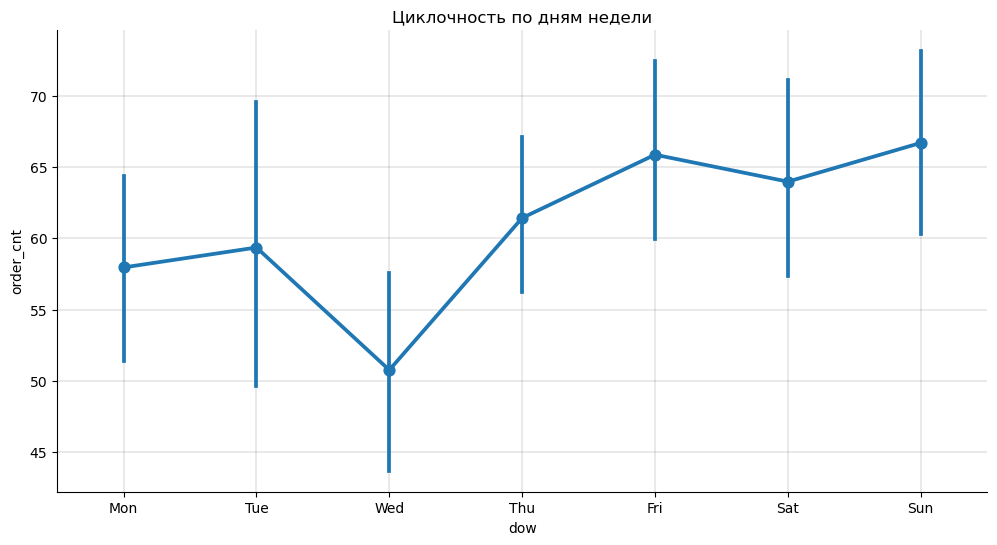

In [60]:

fig, ax = plt.subplots( figsize=(12, 6))
sns.despine(left=False, ax=ax)
sns.pointplot(data=df_weekly_orders, x="dow", y="order_cnt",
             order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] # задаем правильный порядок дней недели
             )
ax.grid( color='grey', lw=0.25)
ax.set_title("Циклочность по дням недели");


# Шаг 3. Расчёт метрик

1. Оцените по часам и дням недели количество заказов и количество уникальных покупателей. Постройте графики и сделайте вывод о наличии цикличности в покупательской активности.

Оценим значения количества заказов по часам.

In [61]:
gift_daily = gift_df.groupby(gift_df['entry_date'].dt.hour)\
    .agg({'order_id':'nunique'}).rename(columns={'order_id':'order_count'})
gift_daily

,order_count
entry_date,
6,1
7,23
8,474
9,1246
10,1970
11,2025
12,2756
13,2330
14,2079


Построим график распределния заказов по часам.

In [62]:
gift_daily['entry_date'] = gift_daily.index

Text(0.5, 1.0, 'Циклочность по времени')

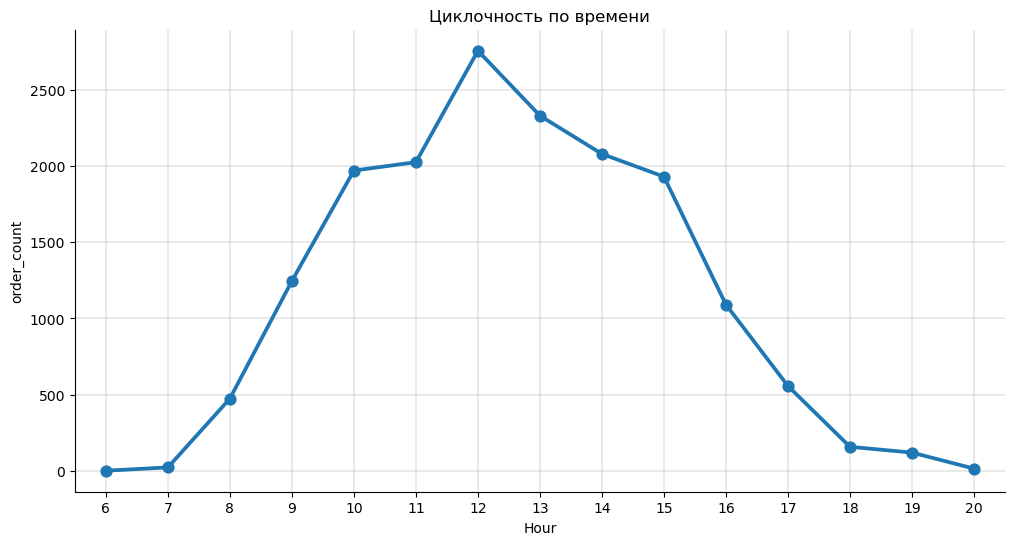

In [63]:
fig, ax = plt.subplots( figsize=(12, 6))
sns.despine(left=False, ax=ax)
sns.pointplot(data=gift_daily, x="entry_date", y="order_count")
ax.grid( color='grey', lw=0.25)
plt.xlabel('Hour')
ax.set_title("Циклочность по времени")

На графике распределения заказов по часам видно, что количество заказов достигает своего пикового значения в 12 часов и потом постепенно падает.

Далее найдём распределние количества заказов по дням недели

In [64]:
df_weekly_orders = df_raw.loc[df_raw["date"] > '2019-01-01']\
    .assign(dow=lambda row: row["entry_date"].dt.strftime("%a"),
            num_dow=lambda row: row["entry_date"].dt.weekday,
           week_date=lambda row: row["entry_date"].dt.to_period("W").dt.start_time)\
    .groupby(["week_date", "dow", "num_dow"], as_index=False)\
    .agg({"order_id": "nunique"})\
    .rename(columns={"order_id": "order_cnt"})
df_weekly_orders.head()

,week_date,dow,num_dow,order_cnt
0,2018-12-31,Fri,4,72
1,2018-12-31,Sat,5,17
2,2018-12-31,Sun,6,41
3,2018-12-31,Thu,3,56
4,2018-12-31,Wed,2,59


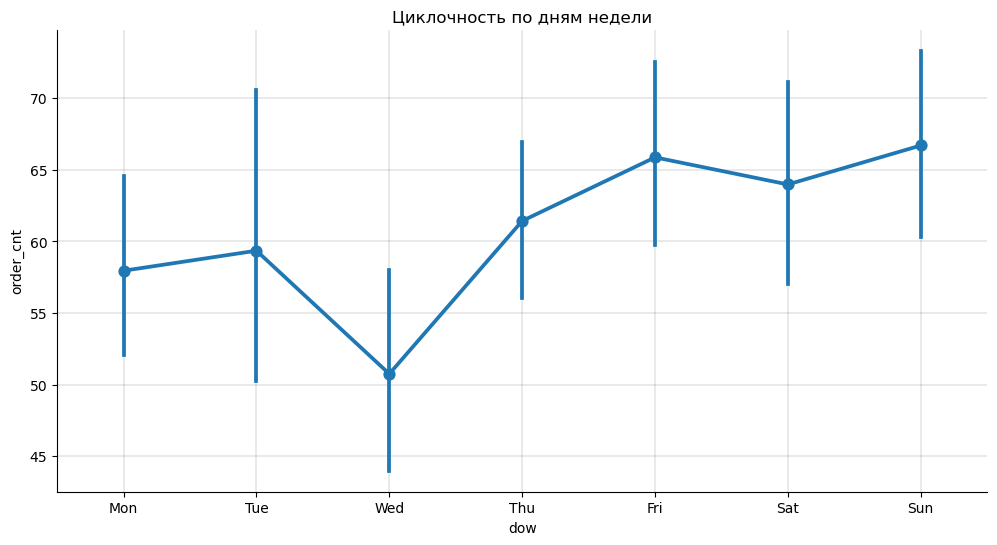

In [65]:
fig, ax = plt.subplots( figsize=(12, 6))
sns.despine(left=False, ax=ax)
sns.pointplot(data=df_weekly_orders, x="dow", y="order_cnt",
             order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] # задаем правильный порядок дней недели
             )
ax.grid( color='grey', lw=0.25)
ax.set_title("Циклочность по дням недели");


По графику видно, что минимальное количество заказов достигается в середине недели. Потом значение растёт и находится на стабильно высоком уровне с пятницы по воскресенье.

2. Рассчитайте по месяцам среднюю выручку с клиента в день и количество уникальных покупателей. Сделайте вывод о наличии или отсутствии сезонности, если это возможно.

In [66]:
gift_df['date'] = pd.to_datetime(gift_df['date'])
gift_df['month'] = gift_df['date'].dt.month
gift_df['day'] = gift_df['date'].dt.day

/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/311028339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gift_df['date'] = pd.to_datetime(gift_df['date'])
/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/311028339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gift_df['month'] = gift_df['date'].dt.month
/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/311028339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Расчитаем по месяцам среднюю выручку с клиента в день.

In [67]:
avg_revenue = gift_df.groupby(['month', 'day']).agg({'position_sum':'sum', 'customer_id':'nunique'})
avg_revenue = pd.DataFrame(avg_revenue['position_sum'] / avg_revenue['customer_id'])

avg_revenue_per_day = avg_revenue.groupby('month').mean()
avg_revenue_per_day.rename(columns={0:'avg_revenue'}, inplace=True)
avg_revenue_per_day

,avg_revenue
month,
1,34285.144745
2,37910.709432
3,37389.788535
4,38221.286760
5,37754.358077
6,37540.680834
7,38092.284009
8,38877.154914
9,42113.198262


Построим график для средней выручки с клиента в день по месяцам.

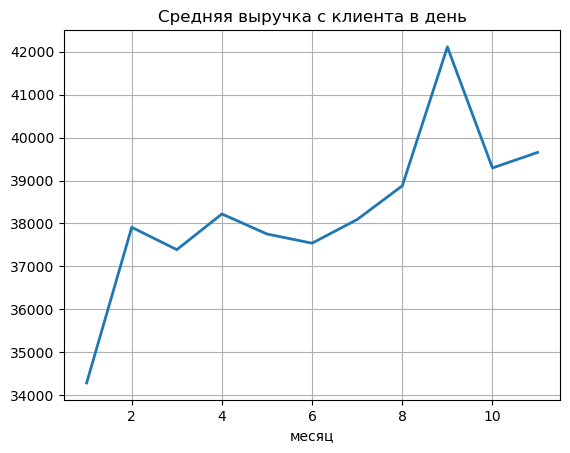

In [68]:
avg_revenue_per_day['month'] = avg_revenue_per_day.index

plt.plot(avg_revenue_per_day['month'], avg_revenue_per_day['avg_revenue'], linewidth=2)
plt.title('Cредняя выручка с клиента в день')
plt.xlabel('месяц')
plt.grid(True)

plt.show() 

На графике видно, что средняя выручка с клиента почти весь год растёт и достигает своего максимума в сентябре. Потом заметен спад в значения в октябре и ноябре.

Расчитаем количество уникальных покупателей по месяцам.

In [69]:
unq_cust = gift_df.groupby('month').agg({'customer_id':'nunique'})
unq_cust

,customer_id
month,
1,846
2,785
3,922
4,870
5,979
6,1009
7,1040
8,934
9,1157


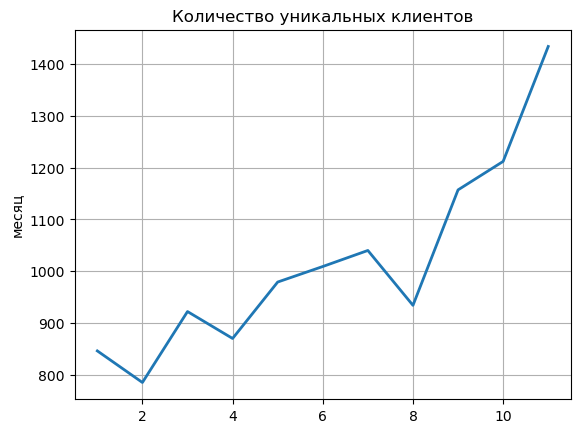

In [70]:
unq_cust['month'] = unq_cust.index

plt.plot(unq_cust.index, unq_cust['customer_id'], linewidth=2)
plt.title('Количество уникальных клиентов')
plt.ylabel('месяц')
plt.grid(True)

plt.show() 

Количество уникальных клиентов растёт весь год. Заметны лишь небольшие падения в феврале, апреле и августе.

3. Рассчитайте стики-фактор за второй и третий квартал 2019 года.

Расчитаем стики - фактор. Можно заметить, что весь второй квартал значение стики - фактора падает. В первом месяце третьего квартала значение близко к значению прошлого месяца, однако потом наблюдается резкий рост показателя в августе. Далее в сентябре очередной спад.

In [71]:
gift_df_new = gift_df[(gift_df['month'] >= 4) & (gift_df['month'] <= 9)]

# Расчитаем DAU
dau = gift_df_new.groupby(['month', 'day']).agg({'customer_id':'nunique'})

# Расчитаем средний DAU по месяцам
dau = dau.groupby('month').agg({'customer_id':'mean'})

# Расчитаем MAU
mau = gift_df.groupby('month').agg({'customer_id':'nunique'})

sticky = pd.DataFrame(dau['customer_id'] / mau['customer_id']).dropna()
sticky

,customer_id
month,
4,0.059457
5,0.055669
6,0.049187
7,0.048967
8,0.054561
9,0.049531


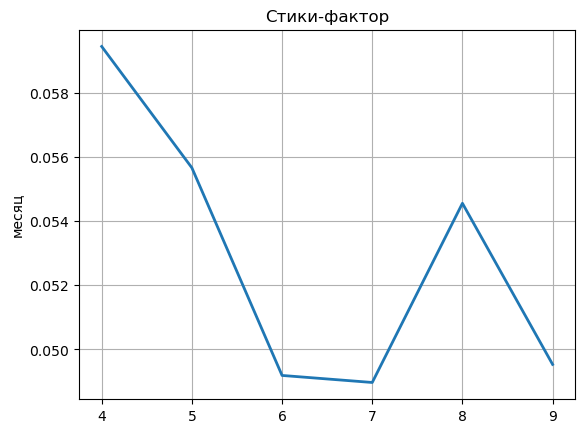

In [72]:
plt.plot(sticky.index, sticky['customer_id'], linewidth=2)
plt.title('Стики-фактор')
plt.ylabel('месяц')
plt.grid(True)

plt.show() 

Значение стики-фактора снижается весь второй квартал. В третьем квартале значение резко поднимается в августе и потом снова падает.

4. Составьте профиль каждого клиента, включите в профиль количество заказов, дату первого и последнего заказа, общую сумму всех заказов, среднюю цену заказа, а также другие показатели по вашему выбору.

In [73]:
gift_df

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry,position_sum,date,month,day
43,2019-05-01 13:40:00,6850,4734,4,375,740,891,28,белый металлический фонарь,1500,2019-05-01,5,1
44,2019-07-01 13:17:00,7130,5702,8,339,740,891,28,белый металлический фонарь,2712,2019-07-01,7,1
45,2019-07-01 16:34:00,7159,5133,4,375,740,891,28,белый металлический фонарь,1500,2019-07-01,7,1
46,2019-09-01 12:53:00,7190,3265,13,375,740,891,28,белый металлический фонарь,4875,2019-09-01,9,1
47,2019-09-01 15:13:00,7207,4201,4,375,740,891,28,белый металлический фонарь,1500,2019-09-01,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353361,2019-08-12 14:38:00,48078,5585,4,295,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,1180,2019-08-12,8,12
353362,2019-08-12 15:51:00,48098,6202,32,255,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,8160,2019-08-12,8,12
353363,2019-08-12 16:30:00,48105,-1,1,579,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,579,2019-08-12,8,12
353364,2019-09-12 10:03:00,48158,-1,3,579,455,1600,28,кремовый подвесной держатель в виде сердца в ф...,1737,2019-09-12,9,12


In [74]:
customer_profile = gift_df.groupby(['customer_id','order_id']).agg(order_sum=('position_sum', 'sum'),
                                                                   order_date=('date', 'unique')) 
customer_profile.reset_index(inplace=True)

customer_profile['order_date'] = customer_profile['order_date'].apply(lambda x: ', '.join(date.strftime('%Y-%m-%d') for date in x))

In [75]:
customer_profile = customer_profile.groupby('customer_id').agg(orders_count = ('order_id','nunique'),
                                                               first_order_date=('order_date', 'min'), 
                                                               last_order_date=('order_date', 'max'), 
                                                               total_order_value=('order_sum', 'sum'), 
                                                               mean_order_value=('order_sum', 'mean')) 

In [76]:
customer_profile.reset_index(inplace=True)
customer_profile

,customer_id,orders_count,first_order_date,last_order_date,total_order_value,mean_order_value
0,-1,1101,2019-01-02,2019-11-30,84547008,76791.106267
1,1713,2,2019-05-22,2019-10-28,61114,30557.000000
2,1717,14,2019-01-23,2019-11-30,148035,10573.928571
3,1718,2,2019-02-12,2019-05-08,11886,5943.000000
4,1720,1,2019-07-03,2019-07-03,13290,13290.000000
...,...,...,...,...,...,...
4087,7647,1,2019-05-19,2019-05-19,8900,8900.000000
4088,7648,7,2019-01-03,2019-09-28,93249,13321.285714
4089,7650,1,2019-02-02,2019-02-02,20680,20680.000000
4090,7651,1,2019-11-21,2019-11-21,107107,107107.000000


5. Разделите клиентов на возвратных и нет по признаку наличия повторных покупок, для каждой из групп на основе профилей клиентов (когда это возможно) рассчитайте средние показатели и оцените их.

Рассмотрим возвратных и невозвратных клиентов именно за 2019 год.

In [77]:
customer_profile['return_group'] = (customer_profile['first_order_date']==customer_profile['last_order_date']).astype(int)

Для корректности оценки нужно удалить строку с customer_id равным -1

In [78]:
customer_profile

,customer_id,orders_count,first_order_date,last_order_date,total_order_value,mean_order_value,return_group
0,-1,1101,2019-01-02,2019-11-30,84547008,76791.106267,0
1,1713,2,2019-05-22,2019-10-28,61114,30557.000000,0
2,1717,14,2019-01-23,2019-11-30,148035,10573.928571,0
3,1718,2,2019-02-12,2019-05-08,11886,5943.000000,0
4,1720,1,2019-07-03,2019-07-03,13290,13290.000000,1
...,...,...,...,...,...,...,...
4087,7647,1,2019-05-19,2019-05-19,8900,8900.000000,1
4088,7648,7,2019-01-03,2019-09-28,93249,13321.285714,0
4089,7650,1,2019-02-02,2019-02-02,20680,20680.000000,1
4090,7651,1,2019-11-21,2019-11-21,107107,107107.000000,1


In [79]:
customer_profile = customer_profile[customer_profile['customer_id'] != -1]

Рассмотрим количество, среднюю стоимость одного заказа и совокупную стоимость всех заказов для каждой группы. Получается, что в 2019 году большинство клиентов сделали только один заказ. При этом средняя стоимость такого заказа значительно выше, чем для клиентов сделавших более одного заказа.

In [80]:
customer_profile.groupby('return_group').agg(mean_total_value=('total_order_value','mean'), 
                                             sum_total_value=('total_order_value','sum'),
                                             group_size=('return_group','count'))

,mean_total_value,sum_total_value,group_size
return_group,,,
0,175999.996839,445455992,2531
1,25211.651923,39330177,1560


# Шаг 4. Проведите RFM-сегментацию клиентов

Проведём RFM-сегментацию клиентов на основе портфелей клиентов.

In [81]:
customer_profile

,customer_id,orders_count,first_order_date,last_order_date,total_order_value,mean_order_value,return_group
1,1713,2,2019-05-22,2019-10-28,61114,30557.000000,0
2,1717,14,2019-01-23,2019-11-30,148035,10573.928571,0
3,1718,2,2019-02-12,2019-05-08,11886,5943.000000,0
4,1720,1,2019-07-03,2019-07-03,13290,13290.000000,1
5,1722,1,2019-09-27,2019-09-27,12690,12690.000000,1
...,...,...,...,...,...,...,...
4087,7647,1,2019-05-19,2019-05-19,8900,8900.000000,1
4088,7648,7,2019-01-03,2019-09-28,93249,13321.285714,0
4089,7650,1,2019-02-02,2019-02-02,20680,20680.000000,1
4090,7651,1,2019-11-21,2019-11-21,107107,107107.000000,1


In [82]:
customer_profile['first_order_date'] = pd.to_datetime(customer_profile['first_order_date'])
customer_profile['last_order_date'] = pd.to_datetime(customer_profile['last_order_date'])

/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/740230609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profile['first_order_date'] = pd.to_datetime(customer_profile['first_order_date'])
/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/740230609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profile['last_order_date'] = pd.to_datetime(customer_profile['last_order_date'])


In [86]:
rfm = customer_profile.drop(columns=['mean_order_value', 'return_group'])
rfm['last_order_days'] = rfm['last_order_date'].max() - rfm['first_order_date']
rfm.drop(columns=['first_order_date', 'last_order_date'], inplace=True)

rfm.rename(columns={'last_order_days':'recency',
                    'orders_count':'frequency',
                    'total_order_value':'monetary_value'},
           inplace=True)

rfm['recency'] = rfm['recency'].dt.days

In [87]:
rfm['r'] = pd.cut(rfm['recency'], [-1, 30, 60, 365], labels=[3,2,1])
rfm['f'] = pd.cut(rfm['frequency'], [0, 5, 30, 365], labels=[1,2,3])
rfm['m'] = pd.qcut(rfm['monetary_value'], q=3, labels=[1,2,3])

rfm[['r','f','m']] = rfm[['r','f','m']].astype('str')
rfm['rfm_group'] = rfm['r'] + rfm['f'] + rfm['m'] 

rfm[['r','f','m']] = rfm[['r','f','m']].astype('int')
rfm['rfm_sum'] = rfm[['r','f','m']].sum(axis=1)

Сгруппируем данные по сегментам и подсчитаем их размер с сумму индексов

In [88]:
rfm['customer_id'] = rfm.index
rfm_group = rfm.groupby('rfm_group').agg(unique_customers=('customer_id','nunique'),
                                          rfm_sum=('rfm_sum','mean')).reset_index()
rfm_group.sort_values(by='unique_customers',ascending=False)

,rfm_group,unique_customers,rfm_sum
1,112,1152,4.0
0,111,1034,3.0
2,113,651,5.0
5,123,647,6.0
11,311,183,5.0
8,211,146,4.0
9,212,96,5.0
12,312,69,6.0
4,122,45,5.0
7,133,27,7.0


Построим график treemap для визуализации результатов RFM сегментации:

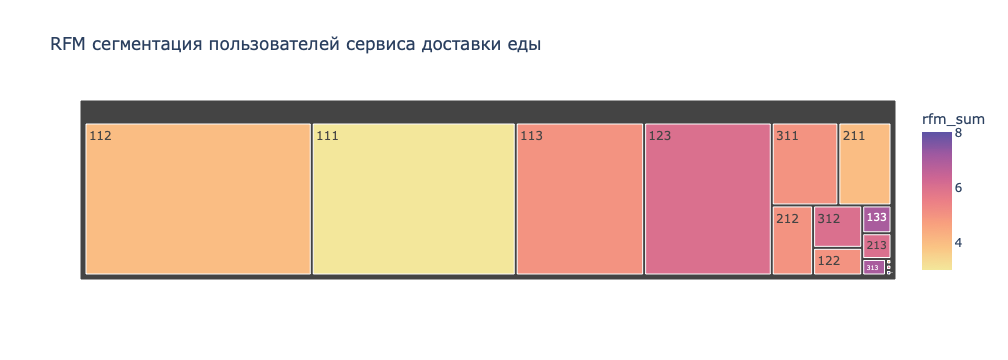

In [90]:
fig = px.treemap(rfm_group, 
                 path=['rfm_group'], # Выбираем RFM-сегменты 
                 values='unique_customers', # Устанавливаем размер - количество покупателей
                 color='rfm_sum', # Цвет сегмента будет определять сумма RFM 
                 color_continuous_scale='Sunset',
                 title='RFM сегментация пользователей сервиса доставки еды')
fig.show() 

Самой большой группой получилась 133 и 311. Клиенты в группе 133 покупали достаточно давно и нечасто, но на большую сумму. Стратегия — реактивация: возвращающие письма, акции, промокоды. Для группы 311 следует увеличить частоту покупок и средний чек. В этом помогут скидки за объём покупок и накопительные программы лояльности.

# Шаг 5. Проверьте статистические гипотезы

1. Сравним доли возвратных и невозвратных клиентов за второй и третий квартал 2019 года при помощи статистического теста.

Создаём отфильтрованные профили клиентов

In [91]:
customer_profile['first_order_date'].dt.month

prfl_2_quarter = customer_profile[(customer_profile['first_order_date'].dt.month > 3)&
                                  (customer_profile['first_order_date'].dt.month < 7)]

prfl_3_quarter = customer_profile[(customer_profile['first_order_date'].dt.month > 6)&
                                  (customer_profile['first_order_date'].dt.month < 10)]

In [92]:
prfl_2_quarter['customer_id'].nunique()

985

In [93]:
prfl_3_quarter['customer_id'].nunique()

710

Проводим группировку для определения возвратных и невозвртаных клиентов.

In [94]:
prfl_2_quarter['return_group'] = (prfl_2_quarter['first_order_date']==prfl_2_quarter['last_order_date']).astype(int)
prfl_2_quarter = prfl_2_quarter.groupby('return_group').agg(mean_total_value=('total_order_value','mean'), 
                                             sum_total_value=('total_order_value','sum'),
                                             group_size=('customer_id','nunique'))

prfl_3_quarter['return_group'] = (prfl_3_quarter['first_order_date']==prfl_3_quarter['last_order_date']).astype(int)
prfl_3_quarter = prfl_3_quarter.groupby('return_group').agg(mean_total_value=('total_order_value','mean'), 
                                             sum_total_value=('total_order_value','sum'),
                                             group_size=('customer_id','nunique'))

/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/363857814.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1d/0v0sy49s3lg9d1py0rqmbfqw0000gn/T/ipykernel_626/363857814.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Вводим дополнительные переменные для возвратных клиентов и для всех клиентов.

In [95]:
successes_2q = prfl_2_quarter.iloc[0,2]
attempts_2q = prfl_2_quarter.iloc[1,2] + successes_2q

successes_3q = prfl_3_quarter.iloc[0,2]
attempts_3q = prfl_3_quarter.iloc[1,2] + successes_3q

In [96]:
print([attempts_2q,attempts_3q])

[985, 710]


Проводим статистический тест.

In [97]:
successes = [successes_2q, successes_3q]
attempts = [attempts_2q, attempts_3q]

alpha = 0.05

z_stat, p_value = proportions_ztest(count=successes, nobs=attempts, alternative='two-sided')

print(f"z-statistic: {z_stat}, p-value: {p_value}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует значимая разница между долями.")
else:
    print("Не отвергаем нулевую гипотезу: значимой разницы между долями нет.") 

z-statistic: 7.8426177420958485, p-value: 4.412496609827787e-15
Отвергаем нулевую гипотезу: существует значимая разница между долями.


In [98]:
gift_df.assign(Q=lambda row: row["entry_date"].dt.to_period("Q"))\
    .groupby("Q").agg({"customer_id": "nunique"})

,customer_id
Q,
2019Q1,1864
2019Q2,2014
2019Q3,2164
2019Q4,2116


В ходе статистического теста была выявлена значимая статистическая разница между долями возвратных и невозвратных клиентов за второй и третий квартал 2019 года

2. Сравним средние чеки в странах с country_id, равному 3, 6 и 24. На основе статистических тестов сделаем вывод о том, отличаются ли средние чеки в этих странах или нет.

Вначале сгруппируем данные по заказу

In [99]:
orders_df = gift_df.groupby('order_id').agg({'position_sum':'sum',
                                             'country_id':'unique'})

orders_df['country_id'] = orders_df['country_id'].apply(lambda x: int(x[0]))
orders_df.head()

,position_sum,country_id
order_id,,
6659,21400,28
6667,39306,28
6668,22248,28
6669,25180,28
6670,7632,28


Теперь профильтруем данные по странам

In [100]:
country_3 = orders_df[orders_df['country_id']==3]
country_6 = orders_df[orders_df['country_id']==6]
country_24 = orders_df[orders_df['country_id']==24]

country_3_orders = country_3['position_sum']
country_6_orders = country_6['position_sum']
country_24_orders = country_24['position_sum']

Вычисляем alpha для проведения трёх статистических тестов при помощи поправки Бонферрони.

In [101]:
alpha = 0.05/3

Проведём статистические тесты

In [102]:
t_stat, p_value = ttest_ind(country_3_orders, country_6_orders,
                            equal_var=False)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует значимая разница между средними значениями чека для страны 3 и для страны 6.")
else:
    print("Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 3 и для страны 6 нет.") 

Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 3 и для страны 6 нет.


In [103]:
t_stat, p_value = ttest_ind(country_3_orders, country_24_orders,
                            equal_var=False)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует значимая разница между средними значениями чека для страны 3 и для страны 24.")
else:
    print("Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 3 и для страны 24 нет.") 

Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 3 и для страны 24 нет.


In [104]:
t_stat, p_value = ttest_ind(country_6_orders, country_24_orders,
                            equal_var=False)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует значимая разница между средними значениями чека для страны 6 и для страны 24.")
else:
    print("Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 6 и для страны 24 нет.") 

Не отвергаем нулевую гипотезу: значимой разницы между средними значениями чека для страны 6 и для страны 24 нет.


Получилось, что нет значимой разницы между чеками для стран с id 3, 6, 24ю

3. Сравним средние DAU для 2 и 3 квартала.

In [105]:
gift_df_2q = gift_df[(gift_df['month'] > 3) & (gift_df['month'] < 7)]
gift_df_3q = gift_df[(gift_df['month'] > 6) & (gift_df['month'] < 10)]

# Расчитаем DAU
dau_2q = gift_df_2q.groupby(['month', 'day']).agg({'customer_id':'nunique'})
dau_3q = gift_df_3q.groupby(['month', 'day']).agg({'customer_id':'nunique'})

# Расчитаем средний DAU по месяцам
dau_2q = dau_2q.groupby('month').agg({'customer_id':'mean'})
dau_3q = dau_3q.groupby('month').agg({'customer_id':'mean'})

In [106]:
t_stat, p_value = ttest_ind(dau_2q['customer_id'], dau_3q['customer_id'],
                            equal_var=False)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует значимая разница между средними значениями DAU для 2 и 3 квартала.")
else:
    print("Не отвергаем нулевую гипотезу: значимой разницы между средними значениями DAU для 2 и 3 квартала нет.") 

Не отвергаем нулевую гипотезу: значимой разницы между средними значениями DAU для 2 и 3 квартала нет.


# Вывод

В ходе исследования ьыли получены данные из двух датасетов gift и gift_entry. Данные были очищены от пропусков и дубликатов. Далее две таблицы были объеденены на основе entry_id. Далее в ходе исследования было обнаружено, что данные содержат аномальные данные об расходах компании. Эти данные были удалены. Далее была найдена цикличность в дневных и недельных данных, а также были расчитаны другие метрики, такие как, средняя выручка с клиента в день и количество уникальных покупателей по месяцам, стики-фактор за второй и третий квартал 2019 года. Также был составлен профиль каждого клиента. Далее была проведена RFM-сегментация и проверены статистические гипотеза.